In [ ]:
#importimg all the necessities
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.metrics import precision_score, confusion_matrix, recall_score, f1_score, roc_auc_score, classification_report
import warnings
warnings.filterwarnings("ignore")


In [ ]:
#reading data
df = pd.read_csv('/content/diabetes_prediction_dataset.csv')

In [ ]:
df.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   gender               100000 non-null  object 
 1   age                  100000 non-null  float64
 2   hypertension         100000 non-null  int64  
 3   heart_disease        100000 non-null  int64  
 4   smoking_history      100000 non-null  object 
 5   bmi                  100000 non-null  float64
 6   HbA1c_level          100000 non-null  float64
 7   blood_glucose_level  100000 non-null  int64  
 8   diabetes             100000 non-null  int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 6.9+ MB


In [ ]:
df['gender'].value_counts()

,count
gender,
Female,58552
Male,41430
Other,18


In [ ]:
#lets drop "other" gender as it takes only 18 rows from the hole dataset
df = df.drop(df[df['gender'] == 'Other'].index)

In [ ]:
df['gender'].value_counts()

,count
gender,
Female,58552
Male,41430


In [ ]:
#replacing gender values to 0 and 1 to make the column suitable for our prediction model
df['gender'] = df['gender'].replace({'Male': 1, 'Female': 0})
df['gender'].value_counts()

,count
gender,
0,58552
1,41430


In [ ]:
#no misses, good
df.isna().sum()

,0
gender,0
age,0
hypertension,0
heart_disease,0
smoking_history,0
bmi,0
HbA1c_level,0
blood_glucose_level,0
diabetes,0


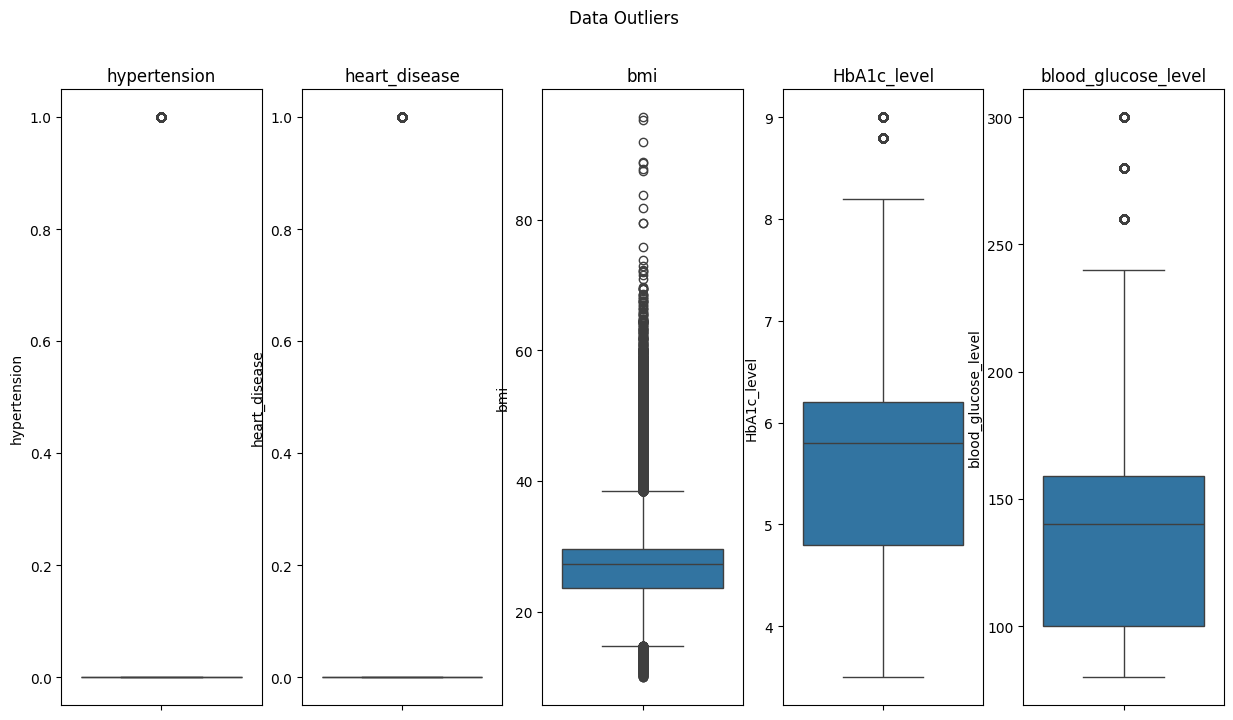

In [ ]:
#checking outliers on plots
fig, axes = plt.subplots(1, 5, sharex = True, figsize = (15,8))
fig.suptitle('Data Outliers')
axes[0].set_title('hypertension')
axes[1].set_title('heart_disease')
axes[2].set_title('bmi')
axes[3].set_title('HbA1c_level')
axes[4].set_title('blood_glucose_level')
sns.boxplot(ax = axes[0], data = df['hypertension'])
sns.boxplot(ax = axes[1], data = df['heart_disease'])
sns.boxplot(ax = axes[2], data = df['bmi'])
sns.boxplot(ax = axes[3], data = df['HbA1c_level'])
sns.boxplot(ax = axes[4], data = df['blood_glucose_level'])

plt.show()

In [ ]:
#counting outliers
numeric_cols = df.select_dtypes(exclude = object)

def clean_outliers(col, df):
  q1 = df[col].quantile(0.25)
  q3 = df[col].quantile(0.75)
  iqr = q3 - q1
  outliers = df[col].loc[(df[col] < q1 - 1.5 * iqr) | (df[col] > q3 + 1.5 * iqr)]
  print(f"Number of {col} outliers: {len(outliers)}")
  return df


for col in numeric_cols:
  df = clean_outliers(col, df)


Number of gender outliers: 0
Number of age outliers: 0
Number of hypertension outliers: 7485
Number of heart_disease outliers: 3942
Number of bmi outliers: 7085
Number of HbA1c_level outliers: 1315
Number of blood_glucose_level outliers: 2038
Number of diabetes outliers: 8500


In [ ]:
# I suppose that if identifying some kind of desease - outliers in health metrics are exactly what is needed for our models.
# So there is no need to drop them

In [ ]:
df.columns

Index(['gender', 'age', 'hypertension', 'heart_disease', 'smoking_history',
       'bmi', 'HbA1c_level', 'blood_glucose_level', 'diabetes'],
      dtype='object')

In [ ]:
df['age'].describe()

,age
count,99982.000000
mean,41.888076
std,22.517206
min,0.080000
25%,24.000000
50%,43.000000
75%,60.000000
max,80.000000


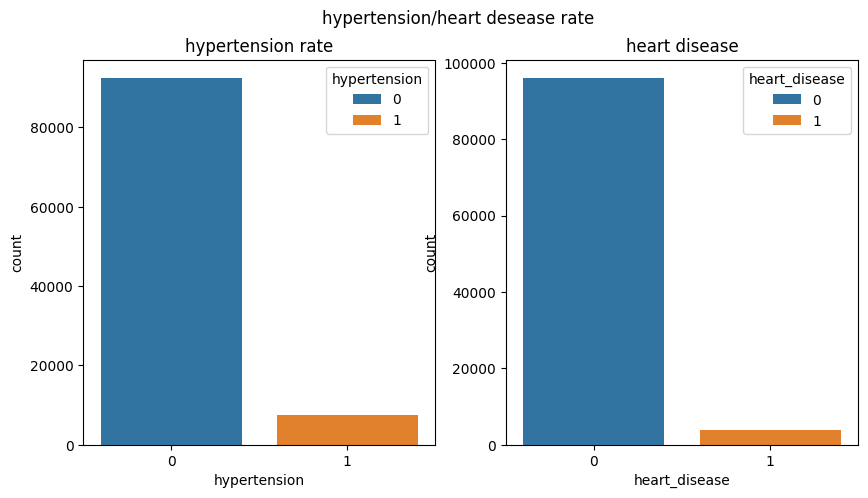

In [ ]:
fig, axes = plt.subplots(1,2, sharex=True, figsize = (10,5))
plt.suptitle('hypertension/heart desease rate')
axes[0].set_title('hypertension rate')
axes[1].set_title('heart disease')
sns.countplot(ax = axes[0], data = df, x = 'hypertension', hue = 'hypertension')
sns.countplot(ax = axes[1], data = df, x = 'heart_disease', hue = 'heart_disease')
plt.show()

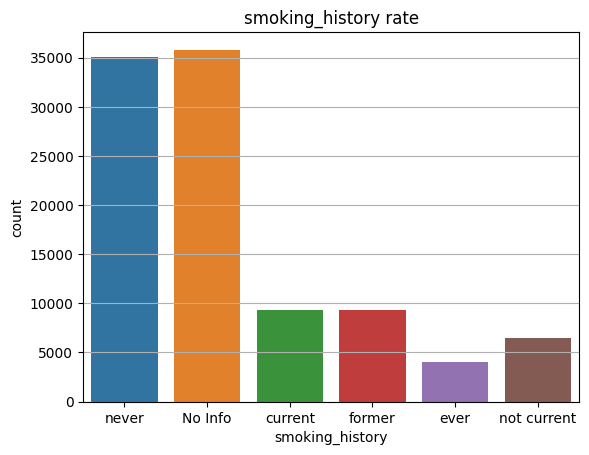

In [ ]:
plt.title('smoking_history rate')
plt.grid()
sns.countplot(data = df, x = 'smoking_history', hue = 'smoking_history')
plt.show()


In [ ]:
#there are only 8.5% sick from the hole dataset
df['diabetes'].value_counts(normalize=True)*100

,proportion
diabetes,
0,91.49847
1,8.50153


In [ ]:
#checking some info on the left numeric columns
df[['bmi', 'HbA1c_level', 'blood_glucose_level']].describe()

,bmi,HbA1c_level,blood_glucose_level
count,99982.000000,99982.000000,99982.000000
mean,27.320757,5.527529,138.057810
std,6.636853,1.070665,40.709469
min,10.010000,3.500000,80.000000
25%,23.630000,4.800000,100.000000
50%,27.320000,5.800000,140.000000
75%,29.580000,6.200000,159.000000
max,95.690000,9.000000,300.000000


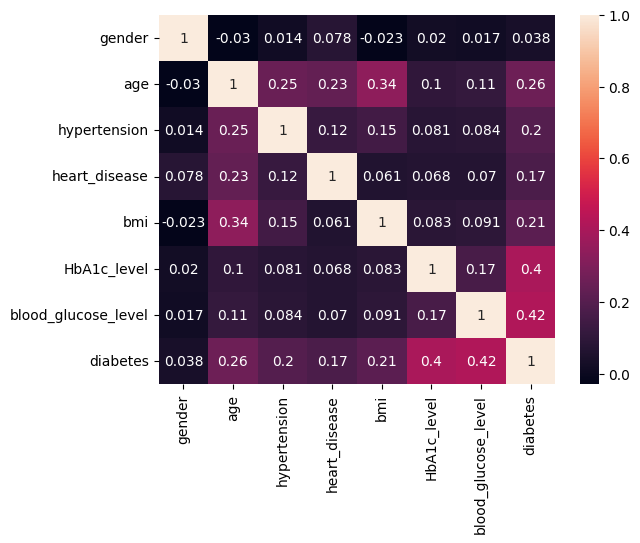

In [ ]:
#checking features correlation with the target
sns.heatmap(df.corr(numeric_only = True), annot = True)
plt.show()

In [ ]:
#dropping week correlation column (<0.1)
df.drop('gender', axis = 1, inplace = True)

In [ ]:
#need to encode object data, otherwise prediction model won't work
cat_cols = df.select_dtypes(include = object).columns.tolist()
cat_cols
#there is an only one object column to be encoded

['smoking_history']

In [ ]:
#creating the model
ohe = OneHotEncoder(sparse_output = False, dtype = np.int64)

In [ ]:
encoded_data = ohe.fit_transform(df[cat_cols])
df_encoded = pd.DataFrame(encoded_data, columns=ohe.get_feature_names_out(cat_cols))
df_encoded.index = df.index #!if not using this string - misses will appear
df = pd.concat([df.drop(cat_cols, axis=1), df_encoded], axis=1)

In [ ]:
#no misses, good
df.isna().sum()

,0
age,0
hypertension,0
heart_disease,0
bmi,0
HbA1c_level,0
blood_glucose_level,0
diabetes,0
smoking_history_No Info,0
smoking_history_current,0
smoking_history_ever,0


In [ ]:
#deviding features and target columns. X for features, y for target
X = df.drop('diabetes', axis = 1)
y = df['diabetes']

In [ ]:
#using train test split method to split the data for training and testing parts
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size = 0.2, random_state = 20)

In [ ]:
#scaling X data for the one and the same demension
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
#firstly use an ordinary logistic regression
lr = LogisticRegression()
lr.fit(X_train, y_train)

LogisticRegression()

In [ ]:
#lets evaluate the precission of our model
y_pred = lr.predict(X_test)

In [ ]:
#for medic al predictions the priority is to have a high recall score. I suppose that 85% is not good enough for sicknes prediction
cr = classification_report(y_pred, y_test)
print(cr)

              precision    recall  f1-score   support

           0       0.99      0.97      0.98     18729
           1       0.63      0.85      0.72      1268

    accuracy                           0.96     19997
   macro avg       0.81      0.91      0.85     19997
weighted avg       0.97      0.96      0.96     19997



In [ ]:
roc = roc_auc_score(y_pred, y_test)
print(roc)

0.9074980802894616


In [ ]:
cm = confusion_matrix(y_pred, y_test)
print(cm)

[[18100   629]
 [  192  1076]]


In [ ]:
#second model is about boosting. Using XGBClassifier
xgc = XGBClassifier()

In [ ]:
#Do not know what parameters are the best, so GridSearchCV will be used to run throug different parameters
parameters = {
    'n_estimators' : [50, 100, 120, 150],
    'max_depth' : [10, 15, 20],
    'learning_rate' : [0.001, 0.005, 0.01, 0.02],
    'booster' : ['gbtree', 'gblinear']

}

In [ ]:
grsearch = GridSearchCV(xgc, parameters)

In [ ]:
grsearch.fit(X_train, y_train)

GridSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_b...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             param_grid={'booster': ['gbtree', 'gblinear'],
                         'learning_rate': [0.001, 0.005, 0.01, 0.02],
                         'max_depth': [10, 15, 20],
                         'n_estimators': [50, 100, 120, 150]})

In [ ]:
#Identifying best parameters according to GridSearchCV
best_model = grsearch.best_estimator_
grsearch.best_params_

{'booster': 'gbtree',
 'learning_rate': 0.02,
 'max_depth': 10,
 'n_estimators': 120}

In [ ]:
grsearch.best_score_

0.9721697818340939

In [ ]:
y_pred = grsearch.predict(X_test)

In [ ]:
#recall 99% for all predicted sick patients looks quite good
cr = classification_report(y_pred, y_test)
print(cr)

              precision    recall  f1-score   support

           0       1.00      0.97      0.98     18830
           1       0.68      0.99      0.80      1167

    accuracy                           0.97     19997
   macro avg       0.84      0.98      0.89     19997
weighted avg       0.98      0.97      0.97     19997



In [ ]:
cm = confusion_matrix(y_pred, y_test)
print(cm)

[[18277   553]
 [   15  1152]]


In [ ]:
roc = roc_auc_score(y_pred, y_test)
print(roc)

0.9788892499116025


In [ ]:
#for the third lets do the same with random forest model
rf = RandomForestClassifier()

In [56]:
parameters = {
    'n_estimators' : [50, 100, 120, 150],
    'max_depth' : [10, 15, 20]
}

In [57]:
gridsearch = GridSearchCV(rf, parameters)
gridsearch.fit(X_train, y_train)

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'max_depth': [10, 15, 20],
                         'n_estimators': [50, 100, 120, 150]})

In [58]:
best_model = grsearch.best_estimator_
grsearch.best_params_

{'booster': 'gbtree',
 'learning_rate': 0.02,
 'max_depth': 10,
 'n_estimators': 120}

In [61]:
y_pred = gridsearch.predict(X_test)

In [62]:
cr = classification_report(y_pred, y_test)
print(cr)

              precision    recall  f1-score   support

           0       1.00      0.97      0.98     18855
           1       0.67      1.00      0.80      1142

    accuracy                           0.97     19997
   macro avg       0.83      0.98      0.89     19997
weighted avg       0.98      0.97      0.97     19997



In [ ]:
cm = confusion_matrix(y_pred, y_test)
print(cm)

[[18271   547]
 [   21  1158]]


In [ ]:
roc = roc_auc_score(y_pred, y_test)
print(roc)

0.9765601907328726


In [ ]:
#support vecto classifier is the last model
svc = SVC(kernel = 'linear')

In [53]:
svc.fit(X_train, y_train)

SVC(kernel='linear')

In [54]:
y_pred = svc.predict(X_test)

In [55]:
#it's ok but not good enough for XGB and Random Forest
cr = classification_report(y_pred, y_test)
print(cr)

              precision    recall  f1-score   support

           0       0.99      0.96      0.98     18906
           1       0.58      0.91      0.71      1091

    accuracy                           0.96     19997
   macro avg       0.79      0.94      0.85     19997
weighted avg       0.97      0.96      0.96     19997

